In [1]:
import pandas as pd
import numpy as np
import pickle  # only if needed for something else here

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.ml_models import RandomForestModel, SVRModel, XGBModel
from sklearn.preprocessing import LabelEncoder

In [4]:
def preprocess_dataframe(df, features, target):
    # 1. Drop rows with missing target values
    df = df.dropna(subset=[target])

    # 2. Handle non-numeric features by encoding them or dropping them
    for col in features:
        if df[col].dtype == 'object':  # If it's a string or non-numeric dtype
            # Check if the column has only a few unique values (suitable for encoding)
            if df[col].nunique() < 20:
                encoder = LabelEncoder()
                df[col] = encoder.fit_transform(df[col].astype(str))
            else:
                # Drop the column if it's not suitable for encoding or too complex
                df = df.drop(columns=[col])

    # 3. Replace invalid numeric values (NaN, inf, -inf)
    df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
    df = df.fillna(0)  # Replace NaN with 0 (or use another imputation strategy)

    # 4. Clip to the range of float32 to avoid overflows
    for col in df.select_dtypes(include=[np.number]).columns:  # Numeric columns only
        df[col] = np.clip(df[col], a_min=np.finfo(np.float32).min, a_max=np.finfo(np.float32).max)

    return df

In [17]:
def train_and_select_features_with_rf(df, target_col, top_n, date_col):
    df = preprocess_dataframe(df, df.columns.difference([target_col, date_col]), target_col)

    # Separate features and target
    X = df.drop(columns=[target_col, date_col])
    y = df[target_col]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

    # Train Random Forest Model
    rf_prelim = RandomForestModel(n_estimators=50, random_state=42)
    rf_prelim.fit(X_train, y_train)

    # Feature importance extraction
    importances = rf_prelim.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    y_pred = rf_prelim.predict(X_test)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Plot predictions
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    plt.show()

    print(feature_importances.head(top_n))
    return rf_prelim, feature_importances['feature'].head(top_n).tolist(), rf_prelim.score(X_test, y_test)

In [18]:
df_full = pd.read_csv("merged_agri_df.csv", parse_dates=["Tarih"])
df_full.dropna()
# Call the training function
model, features, scores = train_and_select_features_with_rf(df_full,
                                                            target_col="Smfdolar",
                                                            top_n=15,
                                                            date_col="Tarih")
print("\nSelected Features after training:\n", features)
print("Scores:", scores)

Train shape: (32636, 57) Test shape: (8160, 57)


KeyboardInterrupt: 

In [22]:
# Features and Target Column
features = df_full.columns.difference(["Smfdolar", "Tarih"])  # Drop target and date columns
target_col = "Smfdolar"  # Target column
date_col = "Tarih"

df_full = preprocess_dataframe(df_full, df_full.columns.difference([target_col, date_col]), target_col)

# Preprocessing and splitting the data
# Remove target column and date column from features
X = df_full.drop(columns=[target_col, date_col])  # Feature matrix
y = df_full[target_col]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train shape
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (32636, 57), Test shape: (8160, 57)


In [23]:
# Import required metrics
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the SVR model
svr_model = SVRModel(kernel='rbf', C=100, epsilon=0.1, name="SupportVectorRegressor")

# Train the SVRModel
svr_model.fit(X_train, y_train)

# Predict values using the test set
y_pred_svr = svr_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_svr)  # Mean Squared Error
r2 = r2_score(y_test, y_pred_svr)  # R² (coefficient of determination)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 588.7982886375872
R² Score: 0.8164917006139445


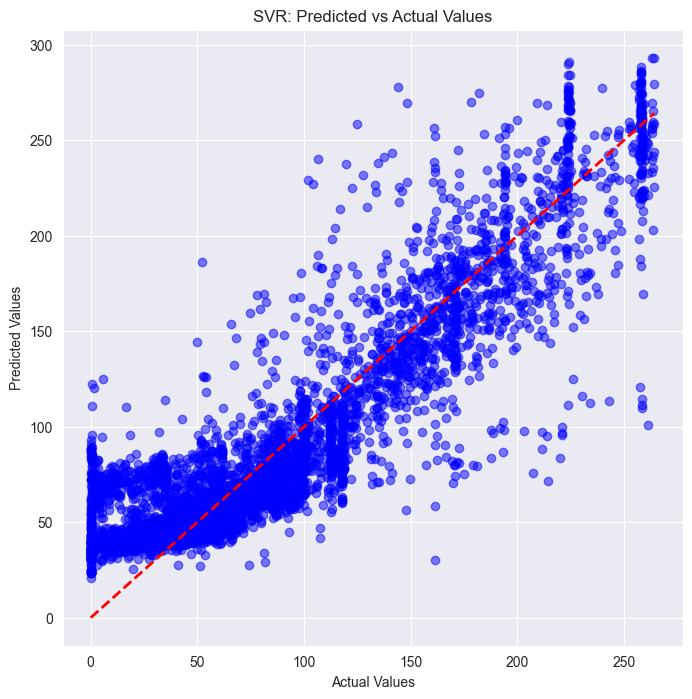

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_svr, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR: Predicted vs Actual Values')
plt.show()


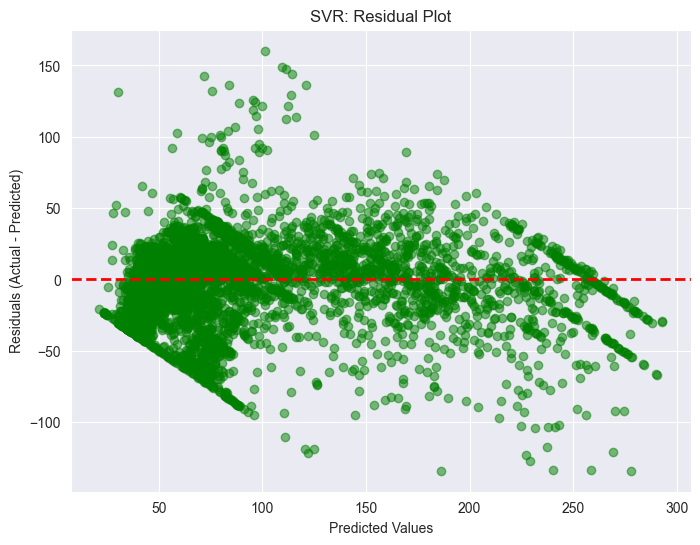

In [25]:
residuals_svr = y_test - y_pred_svr

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_svr, residuals_svr, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('SVR: Residual Plot')
plt.show()


In [34]:
df_full = pd.read_csv("merged_agri_df.csv", parse_dates=["Tarih"])

df_full = preprocess_dataframe(df_full, df_full.columns.difference([target_col, date_col]), target_col)

# Drop unnecessary columns and split the dataset
X = df_full.drop(columns=["Smfdolar", "Tarih"])  # Exclude target and date columns
y = df_full["Smfdolar"]  # Target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (32636, 57), Test shape: (8160, 57)


In [35]:
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating the model

# Initialize the XGBModel object
xgb_model = XGBModel(name="XGBoost", n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print evaluation results
print("XGBModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"R² Score: {r2_xgb}")


XGBModel Evaluation:
Mean Squared Error (MSE): 7.969271635884908
R² Score: 0.9975162504486372


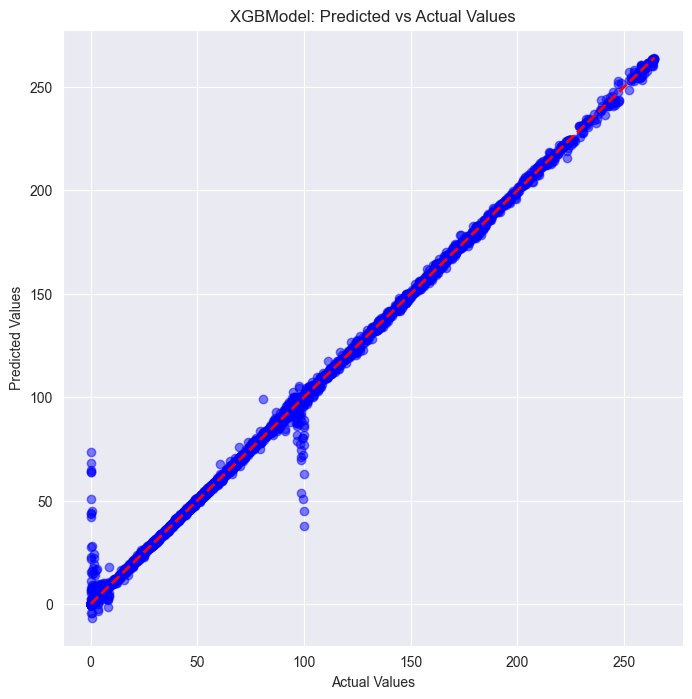

In [36]:
# Predicted vs Actual plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBModel: Predicted vs Actual Values')
plt.show()


# Deep Learning Models

In [2]:
from src.models.dl_models import TimeSeriesDataset, LSTMModel, GRUModel, BiLSTMModel, TransformerModel
import torch

## LSTMModel

In [11]:
df_full = pd.read_csv("merged_agri_df.csv", parse_dates=["Tarih"])

features = df_full.columns.difference(["Smfdolar", "Tarih"])  # Drop target and date columns
target_col = "Smfdolar"  # Target column
date_col = "Tarih"
df_full = preprocess_dataframe(df_full, df_full.columns.difference([target_col, date_col]), target_col)

# Prepare features and target
X = df_full.drop(columns=["Smfdolar", "Tarih"])  # Exclude target and date columns
y = df_full["Smfdolar"]  # Target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Convert to torch tensors
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32)

dataset = TimeSeriesDataset(X_tensor, y_tensor)

Train shape: (32636, 57), Test shape: (8160, 57)


In [23]:
# LSTM example: Initialize, train, and predict
lstm_model = LSTMModel(input_dim=57, hidden_dim=128, num_layers=16, output_dim=1, device='cuda')
lstm_model.fit(X_tensor, y_tensor, epochs=10, batch_size=64, lr=1e-4, verbose=True)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)# Train the model with the dataset
predictions = lstm_model.predict(X_test_tensor)  # Predict on new data

C:\Users\emirs\Documents\Projects\python\learning-from-data-kilowizards\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\emirs\Documents\Projects\python\learning-from-data-kilowizards\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 7654.7734
Epoch [2/10], Loss: 6692.8491
Epoch [3/10], Loss: 6022.6790
Epoch [4/10], Loss: 5460.9995
Epoch [5/10], Loss: 4989.8699
Epoch [6/10], Loss: 4597.6600
Epoch [7/10], Loss: 4275.4166
Epoch [8/10], Loss: 4016.4282
Epoch [9/10], Loss: 3814.7865
Epoch [10/10], Loss: 3663.3739


In [22]:
predictions

array([[59.394512]], dtype=float32)

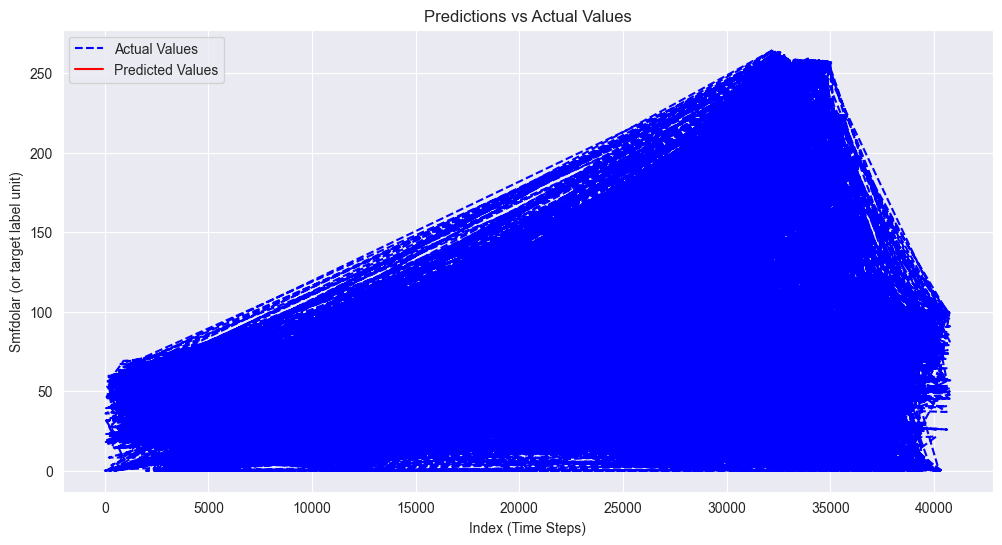

In [14]:
# Assuming `y_test` is the actual target and `predictions` are the model's predictions
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label="Actual Values", color='blue', linestyle='--')

# Plot predicted values
plt.plot(predictions, label="Predicted Values", color='red')

# Add title and labels
plt.title("Predictions vs Actual Values")
plt.xlabel("Index (Time Steps)")
plt.ylabel("Smfdolar (or target label unit)")  # Update this to match your target variable name
plt.legend()

# Show the plot
plt.show()

ValueError: x and y must have same first dimension, but have shapes (8160,) and (1, 1)

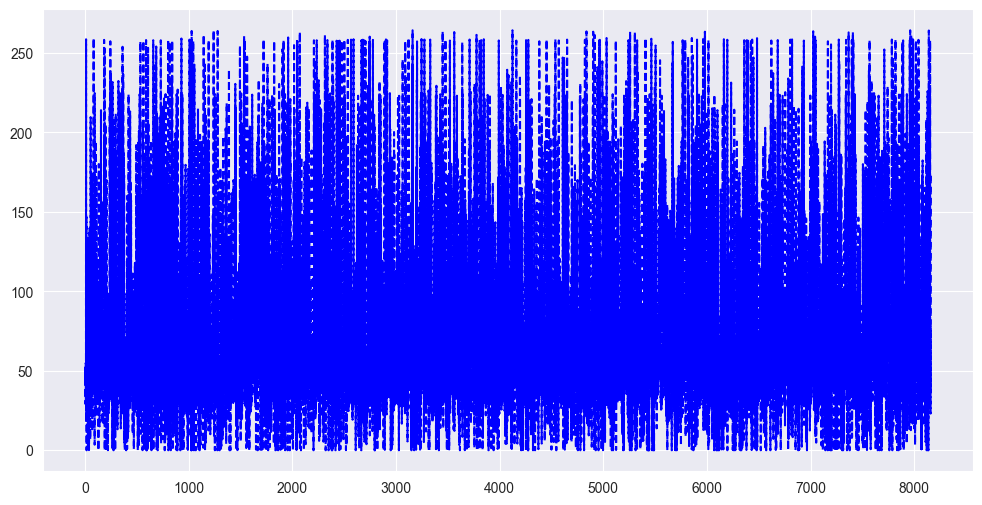

In [17]:
# Create time (or index) for x-axis
time = range(len(y_test))

plt.figure(figsize=(12, 6))

# Actual time series
plt.plot(time, y_test, label="Actual Values", color='blue', linestyle='--')

# Predicted time series
plt.plot(time, predictions, label="Predicted Values", color='red')

# Add title, labels, and legend
plt.title("Time Series Plot: Predictions vs Actual")
plt.xlabel("Time Steps (Index)")
plt.ylabel("Smfdolar (or target unit)")
plt.legend()

plt.show()
